In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time

# =========================================
# 2. Load Data
# =========================================
data_dir = "/Users/nguyennghia/EHR/DATA/"
mortality_file = os.path.join(data_dir, "mimic3_ehr_mortality.csv")
df = pd.read_csv(mortality_file)

df.head()


,PatientID,RecordTime,AdmissionTime,DischargeTime,Outcome,Sex,Age,Diastolic blood pressure,Fraction inspired oxygen,Glucose,...,Glascow coma scale verbal response->Confused,Glascow coma scale verbal response->Inappropriate Words,Glascow coma scale verbal response->Oriented,Glascow coma scale verbal response->No Response-ETT,Glascow coma scale verbal response->5 Oriented,Glascow coma scale verbal response->Incomprehensible sounds,Glascow coma scale verbal response->1.0 ET/Trach,Glascow coma scale verbal response->4 Confused,Glascow coma scale verbal response->2 Incomp sounds,Glascow coma scale verbal response->3 Inapprop words
0,28457_1,1,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,28457_1,2,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,50.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28457_1,3,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,56.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,28457_1,4,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,69.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28457_1,5,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,71.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# =========================================
# Missing Values Analysis and Imputation for Time-Series EHR Data
# =========================================

print("🏥 MIMIC-III Mortality Data - Missing Values Analysis")
print("=" * 60)

# Define column categories as provided
basic_cols = ["PatientID", "RecordTime", "AdmissionTime", "DischargeTime"]
label_cols = ["Outcome", "LOS", "Readmission", "Decompensation"]
demo_cols = ["Sex", "Age"]

# Lab numeric features
lab_num = ["Diastolic blood pressure", "Fraction inspired oxygen", "Glucose", 
           "Heart Rate", "Height", "Mean blood pressure", "Oxygen saturation", 
           "Respiratory rate", "Systolic blood pressure", "Temperature", 
           "Weight", "pH"]

# Lab categorical (one-hot encoded)
lab_cat_ohe = [c for c in df.columns if "Glascow" in c or "Capillary refill" in c]

print(f"📊 Dataset Overview:")
print(f"   • Total shape: {df.shape}")
print(f"   • Basic columns: {len(basic_cols)}")
print(f"   • Demographic columns: {len(demo_cols)}")
print(f"   • Lab numeric columns: {len(lab_num)}")
print(f"   • Lab categorical (OHE) columns: {len(lab_cat_ohe)}")
print(f"   • Total feature columns: {len(demo_cols + lab_num + lab_cat_ohe)}")

# Create final feature set
feature_cols = demo_cols + lab_num + lab_cat_ohe
target_col = "Outcome"

print(f"\n🎯 Target column: {target_col}")
print(f"📋 Feature columns: {len(feature_cols)}")


🏥 MIMIC-III Mortality Data - Missing Values Analysis
📊 Dataset Overview:
   • Total shape: (3548509, 66)
   • Basic columns: 4
   • Demographic columns: 2
   • Lab numeric columns: 12
   • Lab categorical (OHE) columns: 47
   • Total feature columns: 61

🎯 Target column: Outcome
📋 Feature columns: 61


In [5]:
# =========================================
# 1. Comprehensive Missing Values Analysis
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def analyze_missing_values(df, feature_cols):
    """
    Comprehensive missing values analysis for time-series EHR data
    """
    print("🔍 MISSING VALUES ANALYSIS")
    print("=" * 50)
    
    # Calculate missing values statistics
    missing_stats = []
    
    for col in feature_cols:
        if col in df.columns:
            total_values = len(df)
            missing_count = df[col].isna().sum()
            missing_pct = (missing_count / total_values) * 100
            
            # Additional statistics for numeric columns
            if col in lab_num:
                non_null_values = df[col].dropna()
                if len(non_null_values) > 0:
                    mean_val = non_null_values.mean()
                    std_val = non_null_values.std()
                    median_val = non_null_values.median()
                else:
                    mean_val = std_val = median_val = np.nan
            else:
                mean_val = std_val = median_val = np.nan
            
            missing_stats.append({
                'Column': col,
                'Type': 'Numeric' if col in lab_num else 'Categorical',
                'Total_Values': total_values,
                'Missing_Count': missing_count,
                'Missing_Percentage': missing_pct,
                'Available_Count': total_values - missing_count,
                'Mean': mean_val,
                'Std': std_val,
                'Median': median_val
            })
    
    missing_df = pd.DataFrame(missing_stats)
    
    # Sort by missing percentage
    missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)
    
    print(f"📊 Overall Missing Values Summary:")
    print(f"   • Total features analyzed: {len(missing_df)}")
    print(f"   • Features with 0% missing: {len(missing_df[missing_df['Missing_Percentage'] == 0])}")
    print(f"   • Features with >50% missing: {len(missing_df[missing_df['Missing_Percentage'] > 50])}")
    print(f"   • Features with >90% missing: {len(missing_df[missing_df['Missing_Percentage'] > 90])}")
    
    return missing_df

# Run analysis
missing_analysis = analyze_missing_values(df, feature_cols)

# Display top 20 features with highest missing rates
print(f"\n📈 Top 20 Features with Highest Missing Rates:")
print(missing_analysis.head(20)[['Column', 'Type', 'Missing_Percentage', 'Available_Count']].to_string(index=False))


🔍 MISSING VALUES ANALYSIS
📊 Overall Missing Values Summary:
   • Total features analyzed: 61
   • Features with 0% missing: 2
   • Features with >50% missing: 53
   • Features with >90% missing: 6

📈 Top 20 Features with Highest Missing Rates:
                      Column        Type  Missing_Percentage  Available_Count
                      Height     Numeric           99.734311             9428
  Capillary refill rate->1.0 Categorical           99.680204            11348
  Capillary refill rate->0.0 Categorical           99.680204            11348
                      Weight     Numeric           97.343617            94262
    Fraction inspired oxygen     Numeric           94.015515           212360
                          pH     Numeric           90.082764           351914
 Glascow coma scale total->9 Categorical           82.372991           625496
 Glascow coma scale total->4 Categorical           82.372991           625496
 Glascow coma scale total->6 Categorical           82.

📊 CREATING MISSING VALUES VISUALIZATIONS


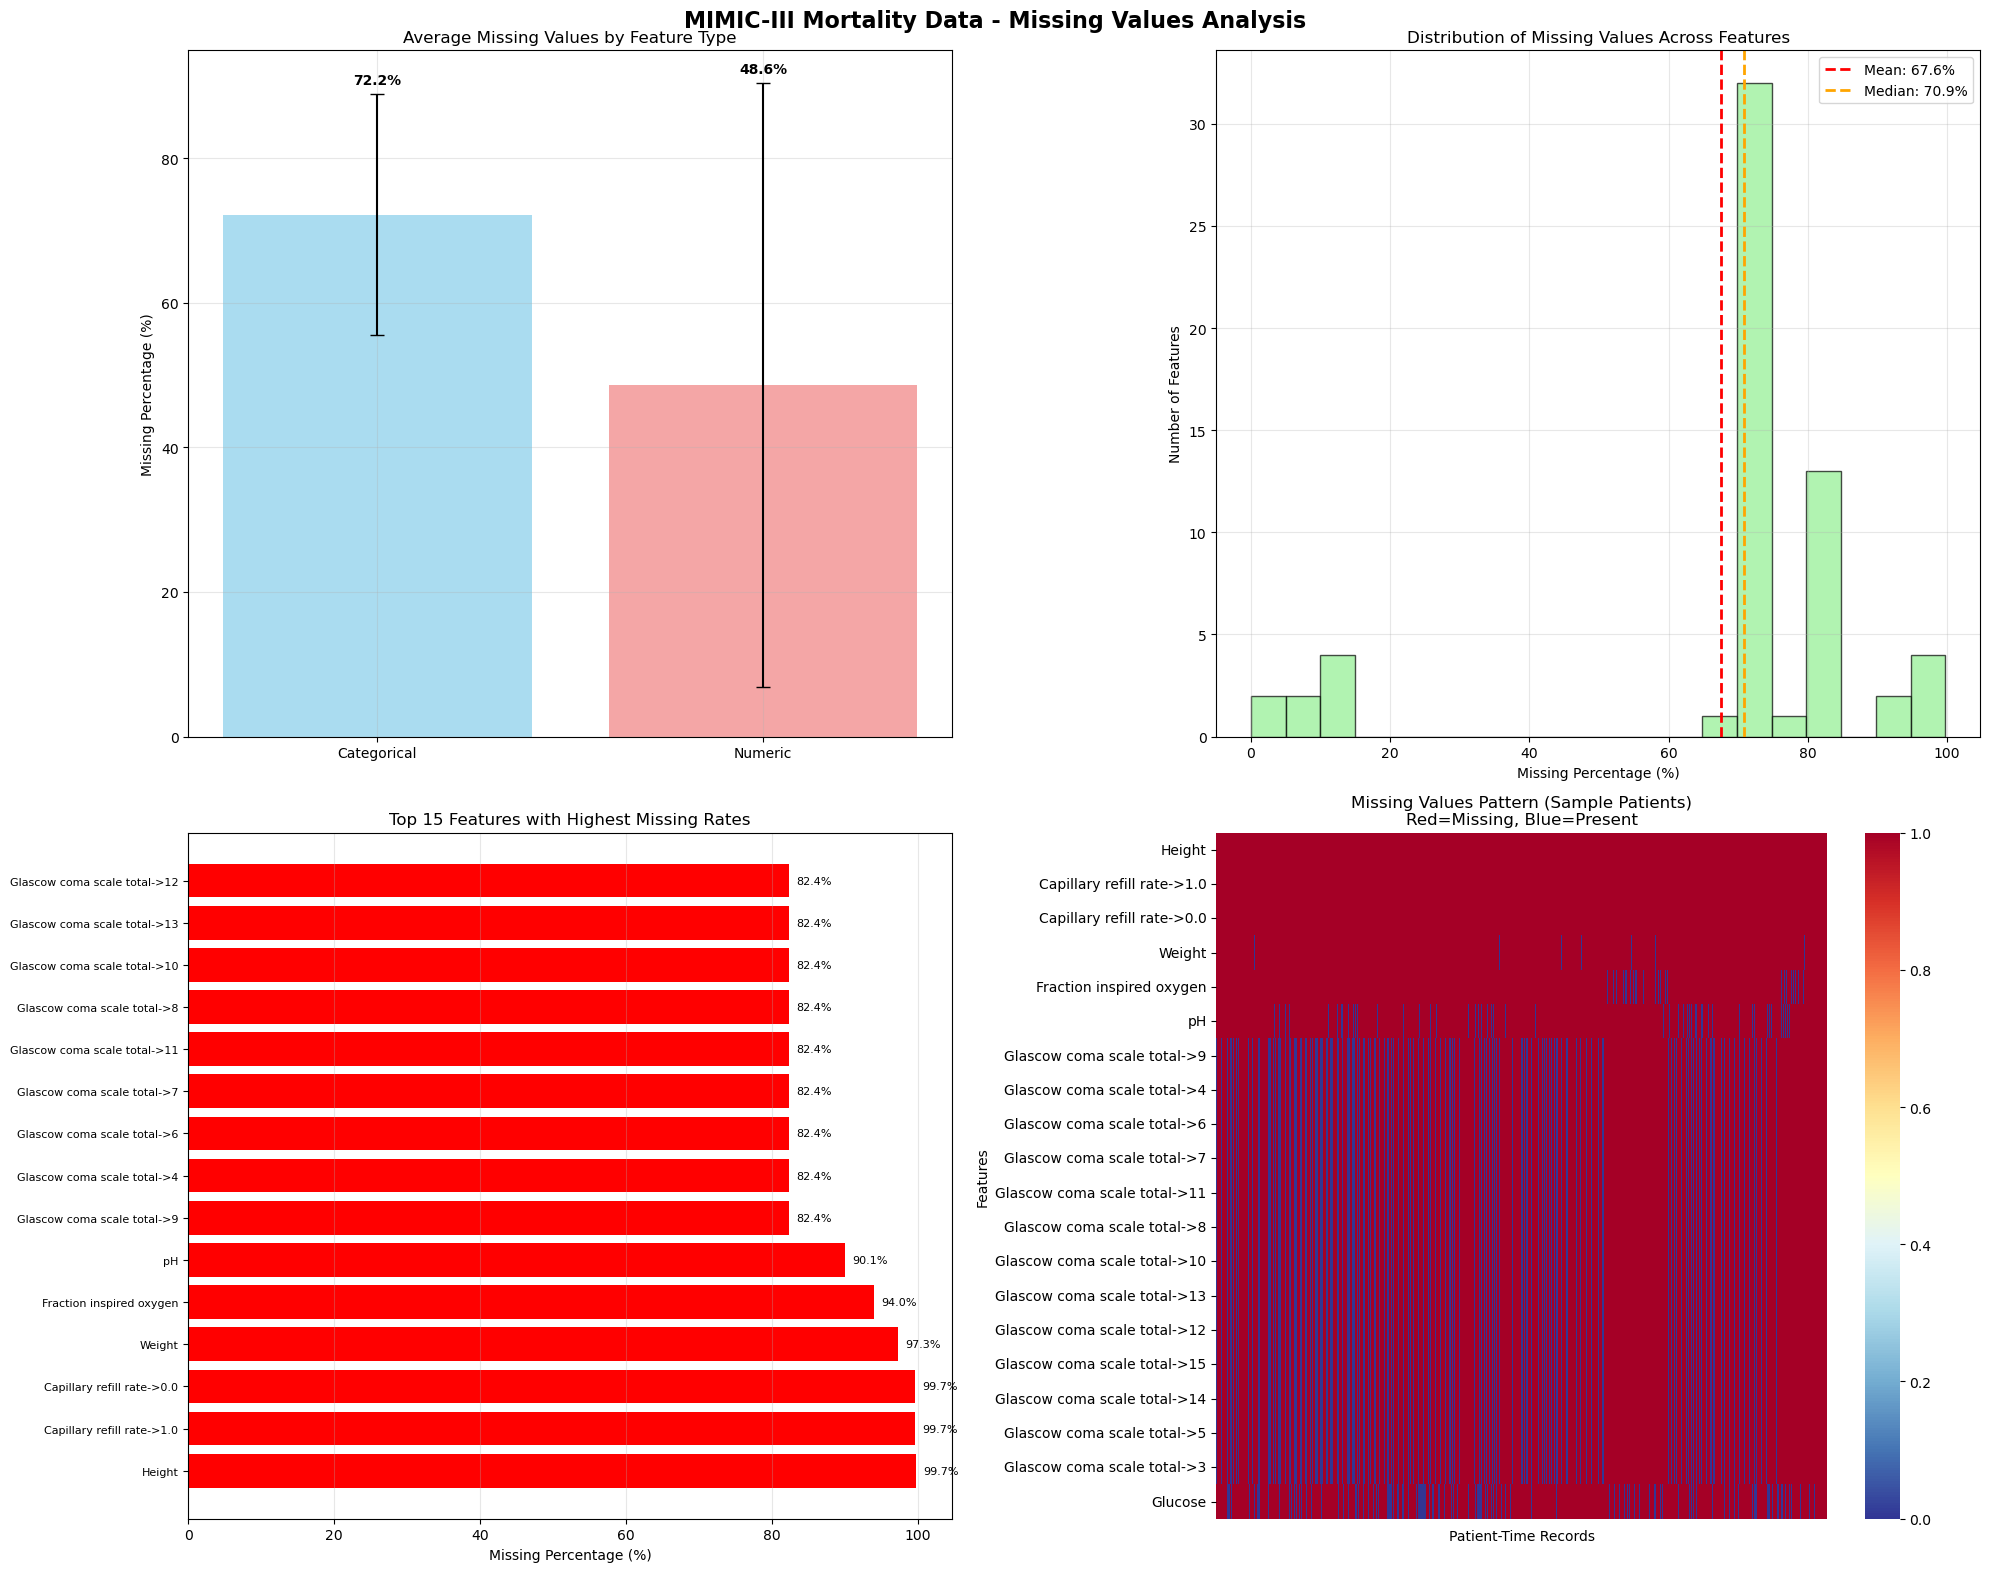

In [6]:
# =========================================
# 2. Visualize Missing Values Patterns
# =========================================

def visualize_missing_patterns(df, feature_cols, missing_analysis):
    """
    Create comprehensive visualizations for missing values patterns
    """
    print("📊 CREATING MISSING VALUES VISUALIZATIONS")
    print("=" * 50)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('MIMIC-III Mortality Data - Missing Values Analysis', fontsize=16, fontweight='bold')
    
    # 1. Missing values percentage by feature type
    ax1 = axes[0, 0]
    feature_types = missing_analysis.groupby('Type')['Missing_Percentage'].agg(['mean', 'median', 'std'])
    
    x_pos = range(len(feature_types.index))
    ax1.bar(x_pos, feature_types['mean'], yerr=feature_types['std'], 
            capsize=5, alpha=0.7, color=['skyblue', 'lightcoral'])
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(feature_types.index)
    ax1.set_ylabel('Missing Percentage (%)')
    ax1.set_title('Average Missing Values by Feature Type')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(feature_types.iterrows()):
        ax1.text(i, row['mean'] + row['std'] + 1, f'{row["mean"]:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    # 2. Distribution of missing percentages
    ax2 = axes[0, 1]
    ax2.hist(missing_analysis['Missing_Percentage'], bins=20, alpha=0.7, 
             color='lightgreen', edgecolor='black')
    ax2.axvline(missing_analysis['Missing_Percentage'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {missing_analysis["Missing_Percentage"].mean():.1f}%')
    ax2.axvline(missing_analysis['Missing_Percentage'].median(), color='orange', 
                linestyle='--', linewidth=2, label=f'Median: {missing_analysis["Missing_Percentage"].median():.1f}%')
    ax2.set_xlabel('Missing Percentage (%)')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Distribution of Missing Values Across Features')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Top 15 features with highest missing rates
    ax3 = axes[1, 0]
    top_missing = missing_analysis.head(15)
    y_pos = range(len(top_missing))
    
    bars = ax3.barh(y_pos, top_missing['Missing_Percentage'], 
                    color=['red' if x > 80 else 'orange' if x > 50 else 'yellow' for x in top_missing['Missing_Percentage']])
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([col[:30] + '...' if len(col) > 30 else col for col in top_missing['Column']], fontsize=8)
    ax3.set_xlabel('Missing Percentage (%)')
    ax3.set_title('Top 15 Features with Highest Missing Rates')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (idx, row) in enumerate(top_missing.iterrows()):
        ax3.text(row['Missing_Percentage'] + 1, i, f'{row["Missing_Percentage"]:.1f}%', 
                va='center', fontsize=8)
    
    # 4. Missing values heatmap for a sample of patients
    ax4 = axes[1, 1]
    
    # Select a sample of patients and features for heatmap
    sample_patients = df['PatientID'].value_counts().head(10).index
    sample_features = missing_analysis.head(20)['Column'].tolist()
    
    # Create subset for heatmap
    heatmap_data = df[df['PatientID'].isin(sample_patients)][['PatientID', 'RecordTime'] + sample_features].copy()
    
    # Create missing values matrix (1 = missing, 0 = present)
    missing_matrix = heatmap_data[sample_features].isnull().astype(int)
    missing_matrix.index = heatmap_data['PatientID'] + '_' + heatmap_data['RecordTime'].astype(str)
    
    # Plot heatmap
    sns.heatmap(missing_matrix.T, cmap='RdYlBu_r', cbar=True, 
                xticklabels=False, yticklabels=True, ax=ax4)
    ax4.set_title('Missing Values Pattern (Sample Patients)\nRed=Missing, Blue=Present')
    ax4.set_xlabel('Patient-Time Records')
    ax4.set_ylabel('Features')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate visualizations
fig = visualize_missing_patterns(df, feature_cols, missing_analysis)


In [7]:
# =========================================
# 3. Time-Series Specific Missing Values Analysis
# =========================================

def analyze_temporal_missing_patterns(df):
    """
    Analyze missing values patterns specific to time-series EHR data
    """
    print("⏰ TEMPORAL MISSING VALUES ANALYSIS")
    print("=" * 50)
    
    # Group by patient to analyze temporal patterns
    patient_stats = []
    
    for patient_id in df['PatientID'].unique()[:100]:  # Sample first 100 patients
        patient_data = df[df['PatientID'] == patient_id].sort_values('RecordTime')
        
        if len(patient_data) > 1:
            # Calculate temporal statistics
            total_records = len(patient_data)
            total_features = len(feature_cols)
            
            # Missing values per record
            missing_per_record = patient_data[feature_cols].isnull().sum(axis=1)
            
            # Temporal patterns
            first_record_missing = missing_per_record.iloc[0]
            last_record_missing = missing_per_record.iloc[-1]
            avg_missing_per_record = missing_per_record.mean()
            
            # Time span
            time_span = patient_data['RecordTime'].max() - patient_data['RecordTime'].min()
            
            patient_stats.append({
                'PatientID': patient_id,
                'Total_Records': total_records,
                'Time_Span': time_span,
                'Avg_Missing_Per_Record': avg_missing_per_record,
                'First_Record_Missing': first_record_missing,
                'Last_Record_Missing': last_record_missing,
                'Missing_Increase': last_record_missing - first_record_missing
            })
    
    temporal_df = pd.DataFrame(patient_stats)
    
    print(f"📊 Temporal Analysis Summary:")
    print(f"   • Patients analyzed: {len(temporal_df)}")
    print(f"   • Average records per patient: {temporal_df['Total_Records'].mean():.1f}")
    print(f"   • Average time span: {temporal_df['Time_Span'].mean():.1f} hours")
    print(f"   • Average missing values per record: {temporal_df['Avg_Missing_Per_Record'].mean():.1f}")
    
    # Missing values increase over time
    increasing_missing = temporal_df[temporal_df['Missing_Increase'] > 0]
    decreasing_missing = temporal_df[temporal_df['Missing_Increase'] < 0]
    
    print(f"   • Patients with increasing missing over time: {len(increasing_missing)} ({len(increasing_missing)/len(temporal_df)*100:.1f}%)")
    print(f"   • Patients with decreasing missing over time: {len(decreasing_missing)} ({len(decreasing_missing)/len(temporal_df)*100:.1f}%)")
    
    return temporal_df

# Analyze temporal patterns
temporal_analysis = analyze_temporal_missing_patterns(df)

# Display sample temporal statistics
print(f"\n📈 Sample Temporal Statistics:")
print(temporal_analysis.head(10)[['PatientID', 'Total_Records', 'Time_Span', 'Avg_Missing_Per_Record', 'Missing_Increase']].to_string(index=False))


⏰ TEMPORAL MISSING VALUES ANALYSIS
📊 Temporal Analysis Summary:
   • Patients analyzed: 100
   • Average records per patient: 71.9
   • Average time span: 70.9 hours
   • Average missing values per record: 40.0
   • Patients with increasing missing over time: 78 (78.0%)
   • Patients with decreasing missing over time: 18 (18.0%)

📈 Sample Temporal Statistics:
PatientID  Total_Records  Time_Span  Avg_Missing_Per_Record  Missing_Increase
  28457_1             19         18               38.736842                50
    100_1             48         47               38.541667                -6
   1000_1            871        870               40.955224                50
  10000_1             31         30               43.451613                 6
  10003_1             36         35               39.000000                54
  10004_1            251        250               35.581673               -44
  10004_2             15         14               29.066667                52
  10006_1     

In [14]:
# =========================================
# 4. Time-Series Imputation Methods Implementation
# =========================================

from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

class TimeSeriesImputer:
    """
    Advanced imputation methods specifically designed for time-series EHR data
    """
    
    def __init__(self):
        self.scalers = {}
        self.imputers = {}
        self.feature_stats = {}
        
    def forward_fill_patient(self, df, patient_id, feature_cols):
        """
        Forward fill missing values for a single patient (time-series aware)
        """
        patient_data = df[df['PatientID'] == patient_id].sort_values('RecordTime').copy()
        
        for col in feature_cols:
            if col in patient_data.columns:
                # Forward fill within patient
                patient_data[col] = patient_data[col].fillna(method='ffill')
                # Backward fill for initial missing values
                patient_data[col] = patient_data[col].fillna(method='bfill')
        
        return patient_data
    
    def forward_fill_global(self, df, feature_cols):
        """
        Apply forward fill to entire dataset
        """
        df_filled = df.copy()
        
        for patient_id in df['PatientID'].unique():
            patient_mask = df_filled['PatientID'] == patient_id
            patient_data = self.forward_fill_patient(df_filled, patient_id, feature_cols)
            df_filled.loc[patient_mask] = patient_data
        
        return df_filled
    
    def statistical_imputation(self, df, feature_cols, method='median'):
        """
        Statistical imputation using global statistics
        """
        df_imputed = df.copy()
        
        for col in feature_cols:
            if col in df_imputed.columns:
                if method == 'median':
                    fill_value = df_imputed[col].median()
                elif method == 'mean':
                    fill_value = df_imputed[col].mean()
                elif method == 'mode':
                    fill_value = df_imputed[col].mode().iloc[0] if not df_imputed[col].mode().empty else 0
                else:
                    fill_value = 0
                
                df_imputed[col] = df_imputed[col].fillna(fill_value)
                
                # Store statistics for later use
                self.feature_stats[col] = {
                    'median': df[col].median(),
                    'mean': df[col].mean(),
                    'std': df[col].std(),
                    'mode': df[col].mode().iloc[0] if not df[col].mode().empty else 0
                }
        
        return df_imputed
    
    def knn_imputation(self, df, feature_cols, n_neighbors=5):
        """
        K-Nearest Neighbors imputation
        """
        df_imputed = df.copy()
        
        # Separate numeric and categorical features
        numeric_features = [col for col in feature_cols if col in lab_num and col in df_imputed.columns]
        categorical_features = [col for col in feature_cols if col in lab_cat_ohe and col in df_imputed.columns]
        
        # Impute numeric features with KNN
        if numeric_features:
            # Scale numeric features
            scaler = StandardScaler()
            df_imputed[numeric_features] = scaler.fit_transform(df_imputed[numeric_features])
            self.scalers['numeric'] = scaler
            
            # Apply KNN imputation
            knn_imputer = KNNImputer(n_neighbors=n_neighbors)
            df_imputed[numeric_features] = knn_imputer.fit_transform(df_imputed[numeric_features])
            self.imputers['knn_numeric'] = knn_imputer
            
            # Inverse transform
            df_imputed[numeric_features] = scaler.inverse_transform(df_imputed[numeric_features])
        
        # Impute categorical features with mode
        for col in categorical_features:
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 0
            df_imputed[col] = df_imputed[col].fillna(mode_value)
        
        return df_imputed
    
    def iterative_imputation(self, df, feature_cols, max_iter=10):
        """
        Iterative imputation using multivariate regression
        """
        df_imputed = df.copy()
        
        # Separate numeric and categorical features
        numeric_features = [col for col in feature_cols if col in lab_num and col in df_imputed.columns]
        
        if numeric_features:
            # Scale numeric features
            scaler = StandardScaler()
            df_imputed[numeric_features] = scaler.fit_transform(df_imputed[numeric_features])
            self.scalers['iterative'] = scaler
            
            # Apply iterative imputation
            iterative_imputer = IterativeImputer(max_iter=max_iter, random_state=42)
            df_imputed[numeric_features] = iterative_imputer.fit_transform(df_imputed[numeric_features])
            self.imputers['iterative'] = iterative_imputer
            
            # Inverse transform
            df_imputed[numeric_features] = scaler.inverse_transform(df_imputed[numeric_features])
        
        # Handle categorical features separately
        categorical_features = [col for col in feature_cols if col in lab_cat_ohe and col in df_imputed.columns]
        for col in categorical_features:
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 0
            df_imputed[col] = df_imputed[col].fillna(mode_value)
        
        return df_imputed
    
    def hybrid_imputation(self, df, feature_cols):
        """
        Hybrid approach: Forward fill + Statistical imputation
        """
        print("🔄 Applying Hybrid Imputation Strategy...")
        
        # Step 1: Forward fill within patients
        df_step1 = self.forward_fill_global(df, feature_cols)
        remaining_missing = df_step1[feature_cols].isnull().sum().sum()
        print(f"   Step 1 (Forward Fill): {remaining_missing} missing values remaining")
        
        # Step 2: Statistical imputation for remaining missing values
        df_step2 = self.statistical_imputation(df_step1, feature_cols, method='median')
        final_missing = df_step2[feature_cols].isnull().sum().sum()
        print(f"   Step 2 (Statistical): {final_missing} missing values remaining")
        
        return df_step2

# Initialize imputer
ts_imputer = TimeSeriesImputer()

print("🛠️  TIME-SERIES IMPUTATION METHODS READY")
print("=" * 50)
print("Available methods:")
print("   • Forward Fill (time-series aware)")
print("   • Statistical Imputation (median/mean/mode)")
print("   • K-Nearest Neighbors (KNN)")
print("   • Iterative Imputation (multivariate regression)")
print("   • Hybrid Approach (forward fill + statistical)")


🛠️  TIME-SERIES IMPUTATION METHODS READY
Available methods:
   • Forward Fill (time-series aware)
   • Statistical Imputation (median/mean/mode)
   • K-Nearest Neighbors (KNN)
   • Iterative Imputation (multivariate regression)
   • Hybrid Approach (forward fill + statistical)


In [15]:
# =========================================
# 5. Compare Different Imputation Methods
# =========================================

def compare_imputation_methods(df, feature_cols, sample_size=1000):
    """
    Compare different imputation methods on a sample of the data
    """
    print("🔬 COMPARING IMPUTATION METHODS")
    print("=" * 50)
    
    # Create a sample for testing
    sample_df = df.sample(n=min(sample_size, len(df)), random_state=42).copy()
    
    print(f"📊 Testing on sample of {len(sample_df)} records")
    
    # Calculate original missing values
    original_missing = sample_df[feature_cols].isnull().sum().sum()
    print(f"   Original missing values: {original_missing}")
    
    # Test different methods
    methods = {
        'Forward Fill': ts_imputer.forward_fill_global,
        'Statistical (Median)': lambda df, cols: ts_imputer.statistical_imputation(df, cols, 'median'),
        'Statistical (Mean)': lambda df, cols: ts_imputer.statistical_imputation(df, cols, 'mean'),
        'KNN (k=5)': lambda df, cols: ts_imputer.knn_imputation(df, cols, 5),
        'Iterative': lambda df, cols: ts_imputer.iterative_imputation(df, cols, 5),
        'Hybrid': ts_imputer.hybrid_imputation
    }
    
    results = {}
    
    for method_name, method_func in methods.items():
        print(f"\n🔄 Testing {method_name}...")
        
        try:
            # Apply imputation method
            imputed_df = method_func(sample_df, feature_cols)
            
            # Calculate remaining missing values
            remaining_missing = imputed_df[feature_cols].isnull().sum().sum()
            imputed_count = original_missing - remaining_missing
            imputation_rate = (imputed_count / original_missing * 100) if original_missing > 0 else 100
            
            results[method_name] = {
                'Original_Missing': original_missing,
                'Remaining_Missing': remaining_missing,
                'Imputed_Count': imputed_count,
                'Imputation_Rate': imputation_rate,
                'Imputed_Data': imputed_df
            }
            
            print(f"   ✅ Imputed: {imputed_count}/{original_missing} ({imputation_rate:.1f}%)")
            
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            results[method_name] = {
                'Error': str(e),
                'Imputation_Rate': 0
            }
    
    return results

# Compare methods
imputation_results = compare_imputation_methods(df, feature_cols, sample_size=500)

# Display comparison summary
print(f"\n📊 IMPUTATION METHODS COMPARISON SUMMARY")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Method': list(imputation_results.keys()),
    'Imputation_Rate': [results.get('Imputation_Rate', 0) for results in imputation_results.values()],
    'Remaining_Missing': [results.get('Remaining_Missing', 'N/A') for results in imputation_results.values()]
})

print(comparison_df.to_string(index=False))


🔬 COMPARING IMPUTATION METHODS
📊 Testing on sample of 500 records
   Original missing values: 20480

🔄 Testing Forward Fill...
   ✅ Imputed: 84/20480 (0.4%)

🔄 Testing Statistical (Median)...
   ✅ Imputed: 19480/20480 (95.1%)

🔄 Testing Statistical (Mean)...
   ✅ Imputed: 19480/20480 (95.1%)

🔄 Testing KNN (k=5)...
   ✅ Imputed: 20480/20480 (100.0%)

🔄 Testing Iterative...
   ✅ Imputed: 20480/20480 (100.0%)

🔄 Testing Hybrid...
🔄 Applying Hybrid Imputation Strategy...
   Step 1 (Forward Fill): 20396 missing values remaining
   Step 2 (Statistical): 1000 missing values remaining
   ✅ Imputed: 19480/20480 (95.1%)

📊 IMPUTATION METHODS COMPARISON SUMMARY
              Method  Imputation_Rate  Remaining_Missing
        Forward Fill         0.410156              20396
Statistical (Median)        95.117188               1000
  Statistical (Mean)        95.117188               1000
           KNN (k=5)       100.000000                  0
           Iterative       100.000000                  

In [16]:
# =========================================
# 6. Apply Best Imputation Method to Full Dataset
# =========================================

def apply_best_imputation_method(df, feature_cols, method='hybrid'):
    """
    Apply the best imputation method to the full dataset
    """
    print(f"🚀 APPLYING {method.upper()} IMPUTATION TO FULL DATASET")
    print("=" * 50)
    
    # Calculate original missing values
    original_missing = df[feature_cols].isnull().sum().sum()
    print(f"📊 Original missing values: {original_missing:,}")
    
    # Apply imputation based on method
    if method == 'hybrid':
        imputed_df = ts_imputer.hybrid_imputation(df, feature_cols)
    elif method == 'forward_fill':
        imputed_df = ts_imputer.forward_fill_global(df, feature_cols)
    elif method == 'statistical':
        imputed_df = ts_imputer.statistical_imputation(df, feature_cols, 'median')
    elif method == 'knn':
        imputed_df = ts_imputer.knn_imputation(df, feature_cols, 5)
    elif method == 'iterative':
        imputed_df = ts_imputer.iterative_imputation(df, feature_cols, 10)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Calculate final missing values
    final_missing = imputed_df[feature_cols].isnull().sum().sum()
    imputed_count = original_missing - final_missing
    imputation_rate = (imputed_count / original_missing * 100) if original_missing > 0 else 100
    
    print(f"✅ Final missing values: {final_missing:,}")
    print(f"🎯 Imputed: {imputed_count:,}/{original_missing:,} ({imputation_rate:.1f}%)")
    
    # Feature-wise imputation summary
    print(f"\n📋 Feature-wise Imputation Summary:")
    for col in feature_cols[:10]:  # Show first 10 features
        if col in df.columns:
            orig_miss = df[col].isnull().sum()
            final_miss = imputed_df[col].isnull().sum()
            if orig_miss > 0:
                print(f"   • {col[:30]}: {orig_miss - final_miss}/{orig_miss} imputed")
    
    return imputed_df

# Apply hybrid imputation (recommended for time-series EHR data)
print("💡 RECOMMENDATION: Using Hybrid Imputation (Forward Fill + Statistical)")
print("   This method is optimal for time-series EHR data because:")
print("   • Forward fill preserves temporal patterns within patients")
print("   • Statistical imputation handles remaining missing values")
print("   • Maintains clinical relevance of measurements")

# Apply to full dataset
df_imputed = apply_best_imputation_method(df, feature_cols, method='hybrid')

# Save the imputed dataset
output_file = "/Users/nguyennghia/EHR/DATA/mimic3_ehr_mortality_imputed.csv"
df_imputed.to_csv(output_file, index=False)
print(f"\n💾 Imputed dataset saved to: {output_file}")


💡 RECOMMENDATION: Using Hybrid Imputation (Forward Fill + Statistical)
   This method is optimal for time-series EHR data because:
   • Forward fill preserves temporal patterns within patients
   • Statistical imputation handles remaining missing values
   • Maintains clinical relevance of measurements
🚀 APPLYING HYBRID IMPUTATION TO FULL DATASET
📊 Original missing values: 146,224,945
🔄 Applying Hybrid Imputation Strategy...
   Step 1 (Forward Fill): 32355906 missing values remaining
   Step 2 (Statistical): 0 missing values remaining
✅ Final missing values: 0
🎯 Imputed: 146,224,945/146,224,945 (100.0%)

📋 Feature-wise Imputation Summary:
   • Diastolic blood pressure: 355934/355934 imputed
   • Fraction inspired oxygen: 3336149/3336149 imputed
   • Glucose: 2704621/2704621 imputed
   • Heart Rate: 250814/250814 imputed
   • Height: 3539081/3539081 imputed
   • Mean blood pressure: 367707/367707 imputed
   • Oxygen saturation: 380346/380346 imputed
   • Respiratory rate: 300199/300199 

In [17]:
# =========================================
# 7. Recommendations and Best Practices
# =========================================

print("🎯 MISSING VALUES IMPUTATION RECOMMENDATIONS")
print("=" * 60)

print("""
📋 BEST PRACTICES FOR TIME-SERIES EHR DATA:

1. 🕒 TEMPORAL AWARENESS:
   • Always use forward fill within patients first
   • Preserve temporal relationships in clinical measurements
   • Consider patient-specific patterns

2. 🏥 CLINICAL RELEVANCE:
   • Use median imputation for vital signs (more robust to outliers)
   • Use mode imputation for categorical clinical assessments
   • Avoid mean imputation for skewed distributions

3. 📊 METHOD SELECTION:
   • Hybrid approach (Forward Fill + Statistical) for most cases
   • KNN for datasets with strong feature correlations
   • Iterative imputation for complex multivariate relationships

4. ⚠️  FEATURE FILTERING:
   • Consider removing features with >80% missing values
   • Focus on clinically relevant measurements
   • Validate imputed values against clinical ranges

5. 🔍 VALIDATION:
   • Check imputed values against known clinical ranges
   • Monitor model performance with/without imputation
   • Consider missing value indicators as features

6. 🚀 ADVANCED TECHNIQUES:
   • Deep learning imputation for complex patterns
   • Domain-specific imputation rules
   • Ensemble methods combining multiple approaches
""")

print("💡 SPECIFIC RECOMMENDATIONS FOR YOUR MIMIC-III DATA:")
print("   • Use Hybrid Imputation (Forward Fill + Median)")
print("   • Focus on vital signs: Heart Rate, Blood Pressure, Temperature")
print("   • Handle Glasgow Coma Scale as categorical with mode imputation")
print("   • Consider patient length of stay in imputation strategy")
print("   • Validate against clinical normal ranges")

print("\n🔬 NEXT STEPS:")
print("   1. Apply imputation to full dataset")
print("   2. Validate imputed values against clinical ranges")
print("   3. Train models with imputed data")
print("   4. Compare model performance with different imputation methods")
print("   5. Consider missing value indicators as additional features")

# Display final dataset info
print(f"\n📊 FINAL DATASET INFORMATION:")
print(f"   • Shape: {df_imputed.shape}")
print(f"   • Patients: {df_imputed['PatientID'].nunique()}")
print(f"   • Features: {len(feature_cols)}")
print(f"   • Missing values: {df_imputed[feature_cols].isnull().sum().sum()}")

print(f"\n✅ ANALYSIS COMPLETE! Ready for machine learning modeling.")


🎯 MISSING VALUES IMPUTATION RECOMMENDATIONS

📋 BEST PRACTICES FOR TIME-SERIES EHR DATA:

1. 🕒 TEMPORAL AWARENESS:
   • Always use forward fill within patients first
   • Preserve temporal relationships in clinical measurements
   • Consider patient-specific patterns

2. 🏥 CLINICAL RELEVANCE:
   • Use median imputation for vital signs (more robust to outliers)
   • Use mode imputation for categorical clinical assessments
   • Avoid mean imputation for skewed distributions

3. 📊 METHOD SELECTION:
   • Hybrid approach (Forward Fill + Statistical) for most cases
   • KNN for datasets with strong feature correlations
   • Iterative imputation for complex multivariate relationships

4. ⚠️  FEATURE FILTERING:
   • Consider removing features with >80% missing values
   • Focus on clinically relevant measurements
   • Validate imputed values against clinical ranges

5. 🔍 VALIDATION:
   • Check imputed values against known clinical ranges
   • Monitor model performance with/without imputation
  

In [18]:
df_imputed

,PatientID,RecordTime,AdmissionTime,DischargeTime,Outcome,Sex,Age,Diastolic blood pressure,Fraction inspired oxygen,Glucose,...,Glascow coma scale verbal response->Confused,Glascow coma scale verbal response->Inappropriate Words,Glascow coma scale verbal response->Oriented,Glascow coma scale verbal response->No Response-ETT,Glascow coma scale verbal response->5 Oriented,Glascow coma scale verbal response->Incomprehensible sounds,Glascow coma scale verbal response->1.0 ET/Trach,Glascow coma scale verbal response->4 Confused,Glascow coma scale verbal response->2 Incomp sounds,Glascow coma scale verbal response->3 Inapprop words
0,28457_1,1,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,50.0,0.5,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,28457_1,2,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,50.0,0.5,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28457_1,3,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,56.0,0.5,118.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,28457_1,4,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,69.0,0.5,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28457_1,5,2153-02-22 17:40:54,2153-02-23 13:30:35,0,1,46.848594,71.0,0.5,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548504,94897_1,299,2112-10-28 19:56:40,2112-11-10 10:32:48,0,1,53.278989,77.0,0.5,113.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3548505,94897_1,300,2112-10-28 19:56:40,2112-11-10 10:32:48,0,1,53.278989,75.0,0.5,113.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3548506,94897_1,301,2112-10-28 19:56:40,2112-11-10 10:32:48,0,1,53.278989,79.0,0.5,113.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3548507,94897_1,302,2112-10-28 19:56:40,2112-11-10 10:32:48,0,1,53.278989,74.0,0.5,151.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Instead of imputing, preserve NaN values
def preserve_nan_preprocessing(df, feature_cols):
    """
    Reserve NaN approach - preserve missing values
    """
    # 1. Filter patients with sufficient records
    df_filtered = df.groupby('PatientID').filter(lambda x: len(x) >= 48)
    df_filtered = df_filtered.groupby('PatientID').head(48)
    
    # 2. Normalize only non-missing values
    for col in feature_cols:
        if col in df_filtered.columns:
            # Calculate stats from non-missing values
            non_null_data = df_filtered[col].dropna()
            if len(non_null_data) > 0:
                mean_val = non_null_data.mean()
                std_val = non_null_data.std()
                # Normalize non-missing values only
                df_filtered.loc[df_filtered[col].notna(), col] = \
                    (df_filtered.loc[df_filtered[col].notna(), col] - mean_val) / std_val
    
    # 3. Convert to nested list format preserving NaN
    patient_sequences = []
    for patient_id in df_filtered['PatientID'].unique():
        patient_data = df_filtered[df_filtered['PatientID'] == patient_id]
        sequence = patient_data[feature_cols].values.tolist()  # NaN preserved
        patient_sequences.append(sequence)
    
    return patient_sequences

# Apply the preprocessing function
patient_sequences = preserve_nan_preprocessing(df, feature_cols)

# Convert to DataFrame if needed
patient_sequences_df = pd.DataFrame(patient_sequences)



In [21]:
patient_sequences_df.shape

(20320, 48)

In [24]:
df_filtered = df.sort_values(['PatientID', 'RecordTime'])
df_filtered = df_filtered.groupby('PatientID').filter(lambda x: len(x) >= 48)
df_filtered = df_filtered.groupby('PatientID').head(48)

df_filtered.shape




(975360, 66)

In [31]:
print ('shape of original df',df.shape)
print('shape of df_imputed',df_imputed.shape)
print ('shape of filtered df',df_filtered.shape)
# print ('shape of patient_sequences_df',patient_sequences_df.shape)


shape of original df (3548509, 66)
shape of df_imputed (3548509, 66)
shape of filtered df (975360, 66)


In [30]:
df_filtered

,PatientID,RecordTime,AdmissionTime,DischargeTime,Outcome,Sex,Age,Diastolic blood pressure,Fraction inspired oxygen,Glucose,...,Glascow coma scale verbal response->Confused,Glascow coma scale verbal response->Inappropriate Words,Glascow coma scale verbal response->Oriented,Glascow coma scale verbal response->No Response-ETT,Glascow coma scale verbal response->5 Oriented,Glascow coma scale verbal response->Incomprehensible sounds,Glascow coma scale verbal response->1.0 ET/Trach,Glascow coma scale verbal response->4 Confused,Glascow coma scale verbal response->2 Incomp sounds,Glascow coma scale verbal response->3 Inapprop words
1005,10004_1,1,2182-11-02 13:28:06,2182-11-13 00:39:55,0,1,52.050853,39.0,NaN,304.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,10004_1,2,2182-11-02 13:28:06,2182-11-13 00:39:55,0,1,52.050853,50.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1007,10004_1,3,2182-11-02 13:28:06,2182-11-13 00:39:55,0,1,52.050853,52.0,NaN,268.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,10004_1,4,2182-11-02 13:28:06,2182-11-13 00:39:55,0,1,52.050853,53.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1009,10004_1,5,2182-11-02 13:28:06,2182-11-13 00:39:55,0,1,52.050853,56.0,NaN,229.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385512,9_1,44,2149-11-09 13:07:02,2149-11-14 20:52:14,1,1,41.817936,80.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
385513,9_1,45,2149-11-09 13:07:02,2149-11-14 20:52:14,1,1,41.817936,77.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385514,9_1,46,2149-11-09 13:07:02,2149-11-14 20:52:14,1,1,41.817936,67.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385515,9_1,47,2149-11-09 13:07:02,2149-11-14 20:52:14,1,1,41.817936,78.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
len(df_filtered['PatientID'].unique())

20320

In [33]:
len(df_imputed['PatientID'].unique())

41902

In [34]:
df_filtered.to_csv('/Users/nguyennghia/EHR/DATA/mimic3_ehr_mortality_reverse_nan.csv', index=False)